In [0]:
SANDBOX_NAME = # Sandbox Name
DATA_PATH = "/data/sandboxes/"+SANDBOX_NAME+"/data/"

In [0]:
from google.colab import drive


In [94]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive




# Workshop de Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Cargar librerías

In [0]:
! pip install sklearn

In [0]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.cross_validation import train_test_split
#from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, make_scorer
#from sklearn.grid_search import GridSearchCV, ParameterGrid
#from sklearn.cluster import KMeans



## Lectura de datos

In [0]:
# Carga de Datos desde Drive

diabetes = pd.read_csv('/content/drive/My Drive/Data_Workshop/diabetic_data.csv')
admission_source = pd.read_csv('/content/drive/My Drive/Data_Workshop/admission_source_id.csv')
admission_type  = pd.read_csv('/content/drive/My Drive/Data_Workshop/admission_type_id.csv')
discharge_disposition = pd.read_csv('/content/drive/My Drive/Data_Workshop/discharge_disposition_id.csv')




### Comprobar correcta lectura de los datos

####*Imprimo las tres primeras lineas de cada fichero para verifcar que se ha cargado el fichero bien*

In [0]:
print(admission_source.head(3))
print()
print(admission_type.head(3))
print()
print(discharge_disposition.head(3))
print(diabetes.head())
print(discharge_disposition.tail(3))



### Juntar todos los datos en el mismo DataFrame

#### *Imprimo los nombres de las columnas de cada fichero para saber por que columnas cruzar *

In [0]:
print(admission_source.columns)
print()
print(admission_type.columns)
print()
print(discharge_disposition.columns)


####*Antes de hacer el merge para unir los ficheros, cambio el nombre de las columnas descripción que se mostraran en el fichero final*

In [206]:
# Cambio de nombres
admission_source.columns=['admission_source_id', 'admission_source_lit']  
admission_type.columns=['admission_type_id', 'admission_type_lit']    
discharge_disposition.columns = ['discharge_disposition_id', 'discharge_disposition_lit']

#Merge de ficheros e imprimo cabecera

df_source= pd.merge(diabetes, admission_source, on=['admission_source_id'], how='inner')
df_type= pd.merge(df_source, admission_type, on=['admission_type_id'], how='inner')
diabetes= pd.merge(df_type, discharge_disposition, on=['discharge_disposition_id'], how='inner')
diabetes.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_source_lit,admission_type_lit,discharge_disposition_lit
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
1,1968528,720936,Caucasian,Female,[70-80),?,6,25,1,10,...,No,No,No,No,Ch,Yes,>30,Physician Referral,None,Not Mapped
2,2223336,558360,AfricanAmerican,Female,[60-70),?,6,25,1,9,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
3,2298006,2519748,Caucasian,Male,[60-70),?,6,25,1,4,...,No,No,No,No,Ch,Yes,NO,Physician Referral,None,Not Mapped
4,2356308,608841,AfricanAmerican,Female,[50-60),?,6,25,1,1,...,No,No,No,No,No,Yes,>30,Physician Referral,None,Not Mapped




### Estudiar las dimensiones del dataset

In [207]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 53 columns):
encounter_id                 101766 non-null int64
patient_nbr                  101766 non-null int64
race                         101766 non-null object
gender                       101766 non-null object
age                          101766 non-null object
weight                       101766 non-null object
admission_type_id            101766 non-null int64
discharge_disposition_id     101766 non-null int64
admission_source_id          101766 non-null int64
time_in_hospital             101766 non-null int64
payer_code                   101766 non-null object
medical_specialty            101766 non-null object
num_lab_procedures           101766 non-null int64
num_procedures               101766 non-null int64
num_medications              101766 non-null int64
number_outpatient            101766 non-null int64
number_emergency             101766 non-null int64
number_inpatient



## Data Wrangling



### Cambiar los nombres de las columnas para que cumplan buenas prácticas

####*Borro del nombre de las columnas puntos, espacios y transformo las palabras a minñusculas*

In [208]:
diabetes.columns = [x.lower().replace(' ','_').replace('.','') for x in diabetes.columns]

diabetes.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'a1cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesmed', 'readmitted',
       'admission_source_lit', 'admission_type_lit',
       'discharge_disposition_lit'],
  



### Estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

####*Para poder estudiar las variables, construyo dos dataframes: uno para las variables categoricas y otro para las variables numéricas*

#### Variables Categóricas: Creo el dataframe y creo un for para que me muestre en los valores únicos de cada variable, y ver  si existen caracteres extraños.

In [209]:
#  Creo el dataframe de Variables Categóricas
list(set(diabetes.dtypes.tolist()))
var_categorical = diabetes.select_dtypes(include = ['O'])

# Muestro los valores únicos de cada una
for col, row in var_categorical.items():  
  print(col, ":" ,var_categorical[col].unique())

race : ['Caucasian' 'AfricanAmerican' 'Other' '?' 'Asian' 'Hispanic']
gender : ['Female' 'Male' 'Unknown/Invalid']
age : ['[0-10)' '[70-80)' '[60-70)' '[50-60)' '[40-50)' '[80-90)' '[30-40)'
 '[10-20)' '[20-30)' '[90-100)']
weight : ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[125-150)' '[175-200)'
 '[25-50)' '[150-175)' '>200']
payer_code : ['?' 'MD' 'SP' 'UN' 'CP' 'MC' 'BC' 'HM' 'PO' 'DM' 'WC' 'CH' 'OG' 'OT' 'CM'
 'SI' 'MP' 'FR']
medical_specialty : ['Pediatrics-Endocrinology' 'Surgery-Cardiovascular/Thoracic'
 'Orthopedics-Reconstructive' 'InternalMedicine' 'Family/GeneralPractice'
 'Cardiology' 'Nephrology' 'Surgery-General' 'Pulmonology' 'Psychiatry'
 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncology'
 'Gastroenterology' 'Surgery-Colon&Rectal' 'Urology'
 'Psychiatry-Child/Adolescent' 'Pediatrics-Pulmonology'
 'Pediatrics-CriticalCare' 'Radiology' 'Emergency/Trauma' 'Otolaryngology'
 'Endocrinology' 'Neurology' '

##### * Sustituyo los valores raros en cada variable e imprimo de nuevo para confirmar que se han sustituidos*

In [210]:
   #Weight
  diabetes.weight= diabetes['weight'].replace('?','')
  print(diabetes['weight'].unique())
  print()

     #Race
  diabetes['race']= diabetes['race'].replace('?','')
  print(diabetes['race'].unique())
  print()
      #Payer Code
  diabetes['payer_code']= diabetes['payer_code'].replace('?','')
  print(diabetes['payer_code'].unique())
  print()
        #diag_2    
  diabetes['diag_2']= diabetes['diag_2'].replace('?','')
  print(diabetes['diag_2'].unique())
  print()
        #diag_3
  diabetes['diag_3']= diabetes['diag_3'].replace('?','')
  print(diabetes['diag_3'].unique())
  print()
          #medical_specialty
  diabetes['medical_specialty']= diabetes['medical_specialty'].replace('?','')
  print(diabetes['medical_specialty'].unique())
  print()

['' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[125-150)' '[175-200)'
 '[25-50)' '[150-175)' '>200']

['Caucasian' 'AfricanAmerican' 'Other' '' 'Asian' 'Hispanic']

['' 'MD' 'SP' 'UN' 'CP' 'MC' 'BC' 'HM' 'PO' 'DM' 'WC' 'CH' 'OG' 'OT' 'CM'
 'SI' 'MP' 'FR']

['' '413' '8' '250' '401' '340' '496' '998' '276' '403' '250.82' '511'
 '567' '785' '512' 'V15' '305' '250.51' '280' '648' '414' '250.02' '618'
 '70' '428' '581' '250.01' '444' '250.6' '411' '157' '997' '425' '571'
 '584' '285' '272' '881' '203' 'V45' '729' '427' '999' '250.03' '250.41'
 '250.12' '599' '440' '710' '491' 'V42' '682' '112' '292' '277' '707'
 '780' '196' '250.93' '642' 'E878' '242' '784' '574' '300' '787' '788'
 '410' '287' '447' '790' '591' '560' '154' '304' '786' '162' '575' '486'
 '424' '518' '426' '456' '867' '530' '493' '585' '38' 'V10' '578' '250.43'
 '278' '462' '402' '34' '250.13' '245' '558' '342' '573' '626' '303'
 '250.53' '458' '569' '435' '996' '535' '536' '319' '41' 'V44' '250.7'
 '562' '250.52' '135' '577

#### *Observo que las variables diag_1, diag_2_ diag_3 tienen valores que empiezan con letras V y E*, además de vacíos.

#### Transformar la variables dependiente "readmitted" en continua,. Cuando sea igual a NO le asigno un 0 y en caso contrario 1.

In [211]:
(var_categorical['readmitted'].value_counts()/var_categorical['readmitted'].shape[0])*100

NO     53.911916
>30    34.928169
<30    11.159916
Name: readmitted, dtype: float64

In [0]:
# creo una variables dummy

dummies = pd.get_dummies(diabetes['readmitted'])

diabetes_dummy = pd.concat([diabetes, dummies], axis=1)      

diabetes_dummy.head()


#### Creo la Variable readmitted_num donde es 1 cuando NO SE READMITE y transformo el tipo de dato

In [220]:
#Usando la última columna  del dummi, uso la columna dummi cuando es NO.

diabetes=diabetes_dummy.rename(columns={'NO':'readmitted_num', '<30': 'readmitted_max30', '>30':'readmitted_min30'})
diabetes['readmitted_num']= diabetes['readmitted_num'].astype('int')
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,metformin-pioglitazone,change,diabetesmed,readmitted,admission_source_lit,admission_type_lit,discharge_disposition_lit,readmitted_max30,readmitted_min30,readmitted_num
0,2278392,8222157,Caucasian,Female,[0-10),,6,25,1,1,...,No,No,No,NO,Physician Referral,None,Not Mapped,0,0,1
1,1968528,720936,Caucasian,Female,[70-80),,6,25,1,10,...,No,Ch,Yes,>30,Physician Referral,None,Not Mapped,0,1,0
2,2223336,558360,AfricanAmerican,Female,[60-70),,6,25,1,9,...,No,No,No,NO,Physician Referral,None,Not Mapped,0,0,1
3,2298006,2519748,Caucasian,Male,[60-70),,6,25,1,4,...,No,Ch,Yes,NO,Physician Referral,None,Not Mapped,0,0,1
4,2356308,608841,AfricanAmerican,Female,[50-60),,6,25,1,1,...,No,No,Yes,>30,Physician Referral,None,Not Mapped,0,1,0


#### Observo la estructura del dataframe luego de la transformación

In [221]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 56 columns):
encounter_id                 101766 non-null int64
patient_nbr                  101766 non-null int64
race                         101766 non-null object
gender                       101766 non-null object
age                          101766 non-null object
weight                       101766 non-null object
admission_type_id            101766 non-null int64
discharge_disposition_id     101766 non-null int64
admission_source_id          101766 non-null int64
time_in_hospital             101766 non-null int64
payer_code                   101766 non-null object
medical_specialty            101766 non-null object
num_lab_procedures           101766 non-null int64
num_procedures               101766 non-null int64
num_medications              101766 non-null int64
number_outpatient            101766 non-null int64
number_emergency             101766 non-null int64
number_inpatient

#### Actualizo mi dataframe de variables categoricas

In [0]:
#  Creo el dataframe de Variables Categóricas
list(set(diabetes.dtypes.tolist()))
var_categorical = diabetes.select_dtypes(include = ['O'])

**Variables Numéricas**

In [0]:
# Variables Numéricas

list(set(diabetes.dtypes.tolist()))
var_numerical = diabetes.select_dtypes(include = ['float64', 'int64'])

  



### Estudiar si hay registros repetidos

In [224]:
# Compruebo si hay algún duplicado

diabetes.duplicated().any()

False



### Estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

In [225]:
col_del=[]
for col, row in diabetes.items():  
  porc=(diabetes[col].value_counts())/ (diabetes.shape[0]) * 100
  if (not porc[porc>95].empty) | (diabetes[col].nunique() == 1):  
      col_del.append(col)  
col_del  
 

['weight',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'acetohexamide',
 'tolbutamide',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone']

#### Borrro las avriables del DataFrame

In [226]:
diabetes.columns
diabetes.drop(col_del, axis='columns', inplace=True)
diabetes.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'a1cresult',
       'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesmed', 'readmitted',
       'admission_source_lit', 'admission_type_lit',
       'discharge_disposition_lit', 'readmitted_max30', 'readmitted_min30',
       'readmitted_num'],
      dtype='object')



### Estudiar los nulos en el dataset

In [227]:
# Cuáles variables contienen un nulo

diabetes.isnull().any()

encounter_id                 False
patient_nbr                  False
race                         False
gender                       False
age                          False
admission_type_id            False
discharge_disposition_id     False
admission_source_id          False
time_in_hospital             False
payer_code                   False
medical_specialty            False
num_lab_procedures           False
num_procedures               False
num_medications              False
number_outpatient            False
number_emergency             False
number_inpatient             False
diag_1                       False
diag_2                       False
diag_3                       False
number_diagnoses             False
max_glu_serum                False
a1cresult                    False
metformin                    False
glimepiride                  False
glipizide                    False
glyburide                    False
pioglitazone                 False
rosiglitazone       



### Estudiar los outliers
#### Actualizo los dataframes de nuevo, luego del borrado

In [0]:
# Luego de borrar las variables del dataset diabetes, vuelvo a dividir variables numéricas y categoricas

# Variables Categóricas
list(set(diabetes.dtypes.tolist()))
var_categorical = diabetes.select_dtypes(include = ['O'])

  
# Variables Numéricas
list(set(diabetes.dtypes.tolist()))
var_numerical = diabetes.select_dtypes(include = ['float64', 'int64'])
 

Variables Numéricas

In [229]:
# Descriptivos para comparar estadisticos y ver outliers

var_numerical.info()

# Variables donde max >>> media
    # number_inpatient ***
    # number_emergency ***
    # number_outpatient ***
    # num_outpatient
    # num_medications
    # num_lab_procedures
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 14 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
number_diagnoses            101766 non-null int64
readmitted_num              101766 non-null int64
dtypes: int64(14)
memory usage: 11.6 MB


Esta función identifica los valores atípicos basada en percentiles.  Los valores marcados con un punto  rojo debajo en el eje x del gráfico son los que se deberian de eliminar de la columna en función del percentil de umbral establecido (95 en este caso).

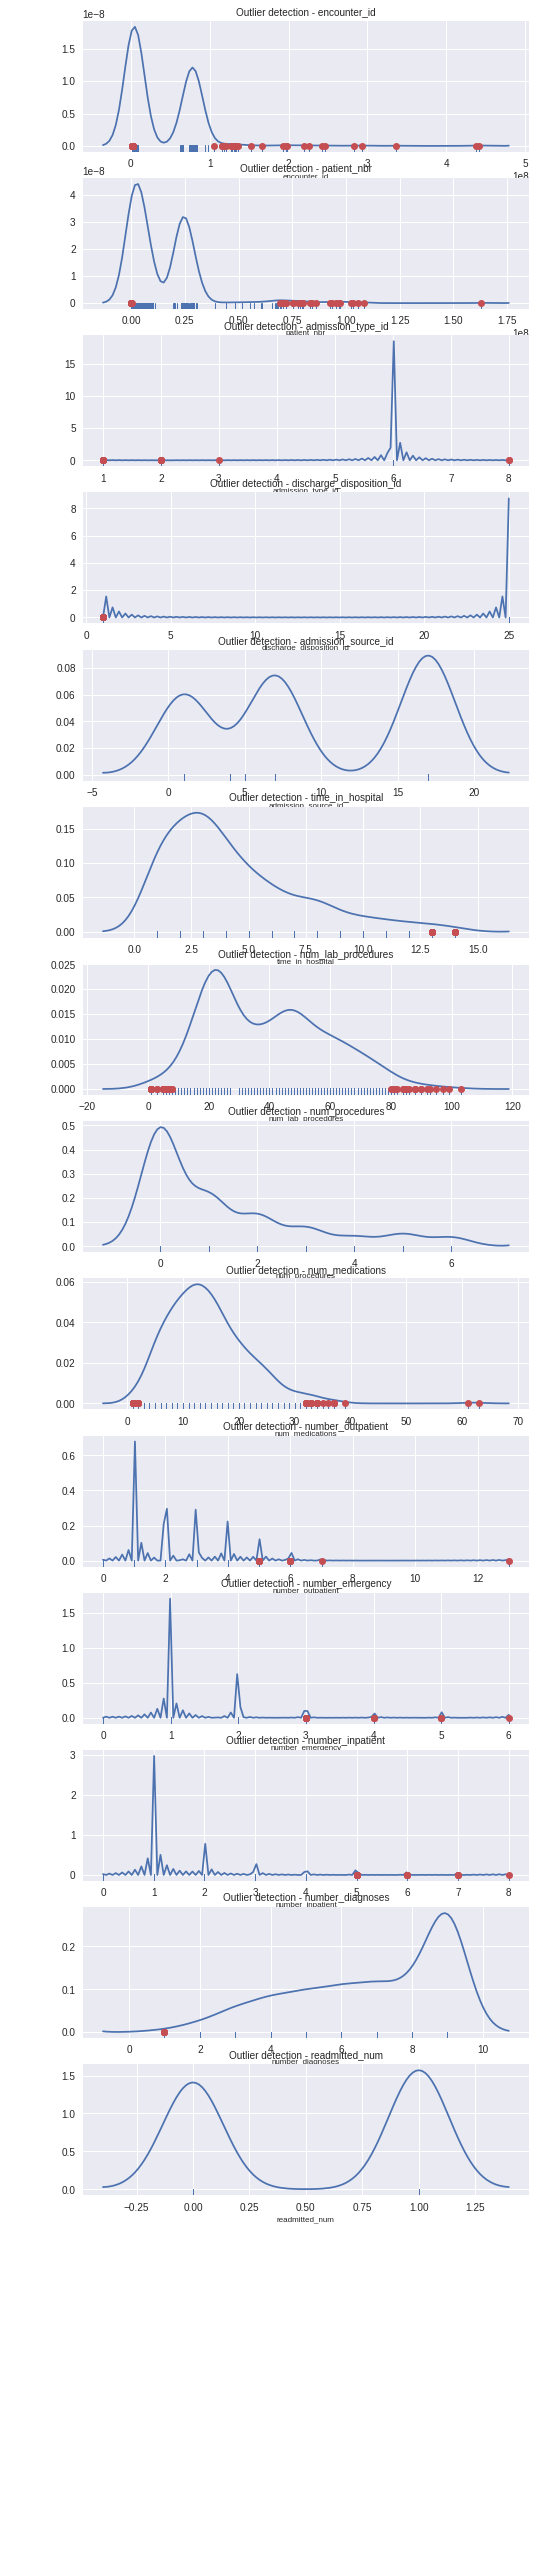

In [230]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)
  
col_names= var_numerical.columns
fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
    x = diabetes[col_val][:1000]
    sns.distplot(x, ax=ax[i], rug=True, hist=False)
    outliers = x[percentile_based_outlier(x)]       # Esto me crea un dataframe con outliers
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    ax[i].set_title('Outlier detection - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)

plt.show()

Variables Categroricas

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


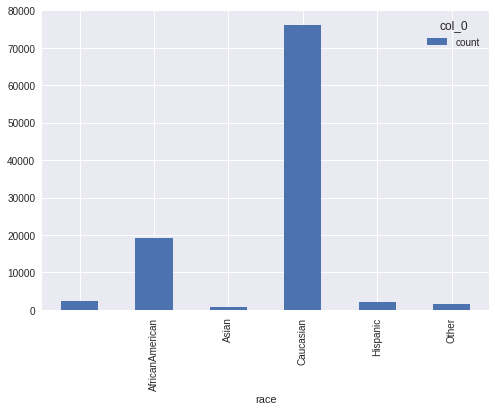

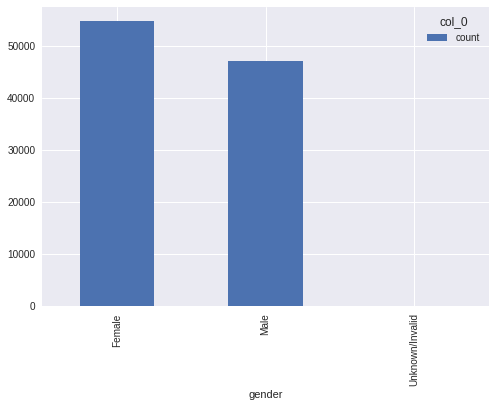

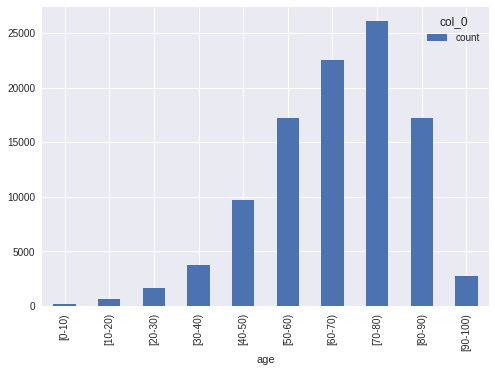

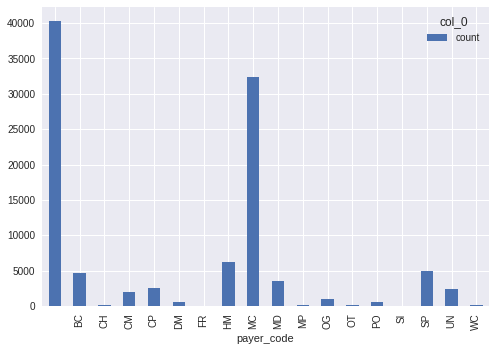

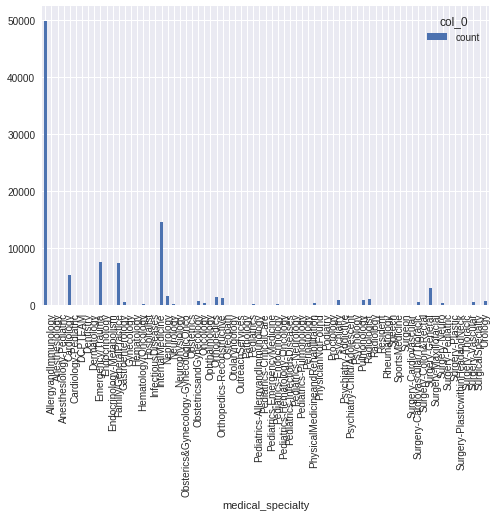

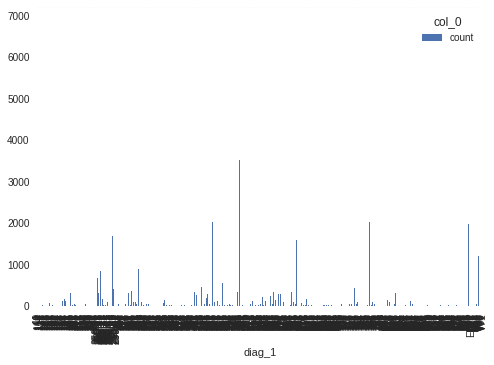

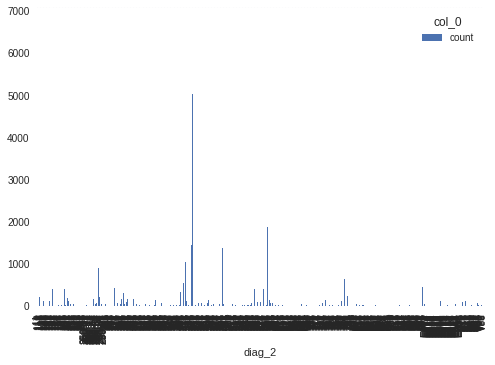

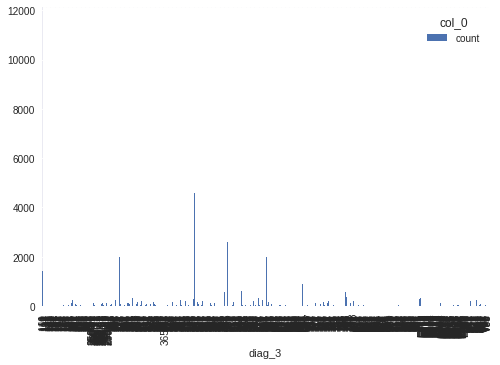

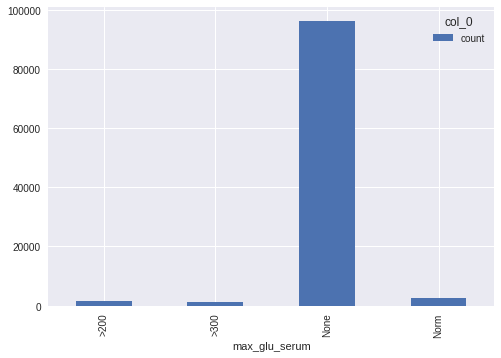

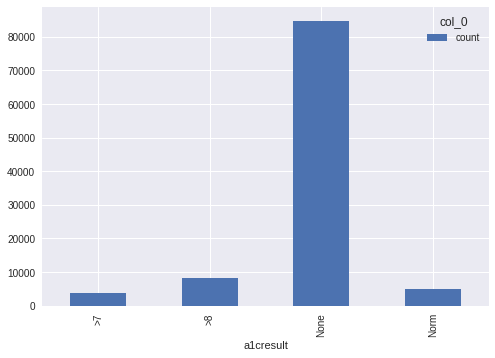

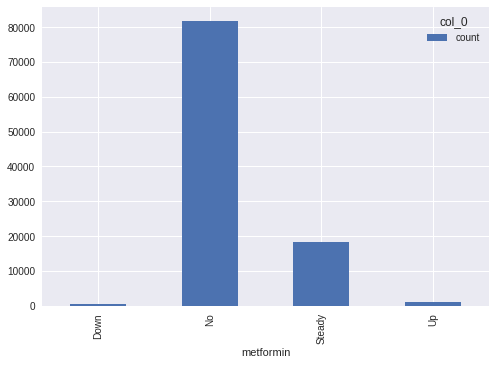

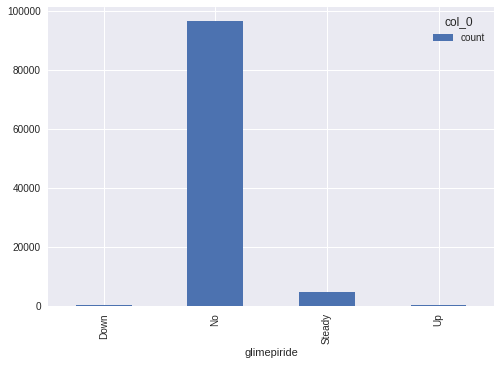

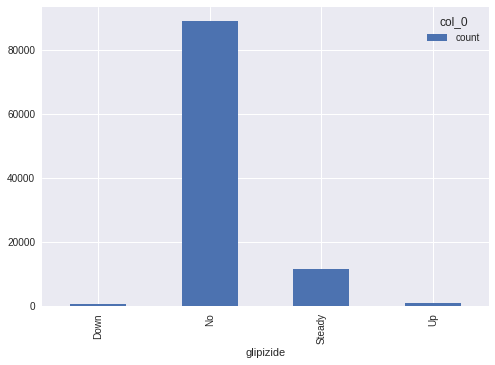

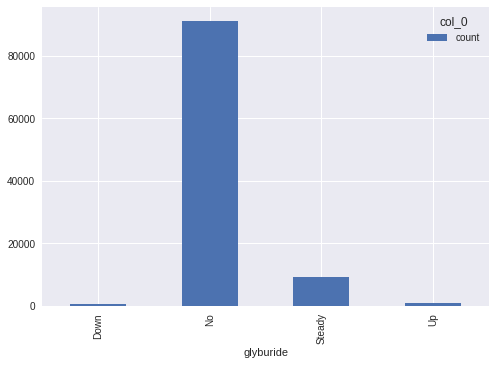

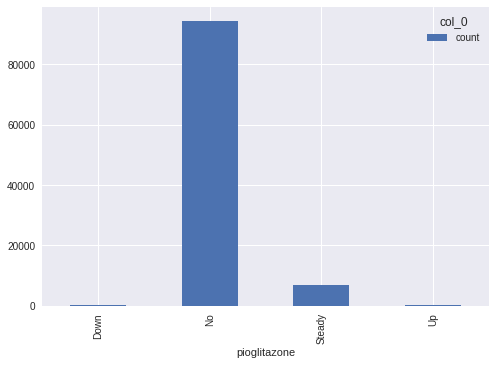

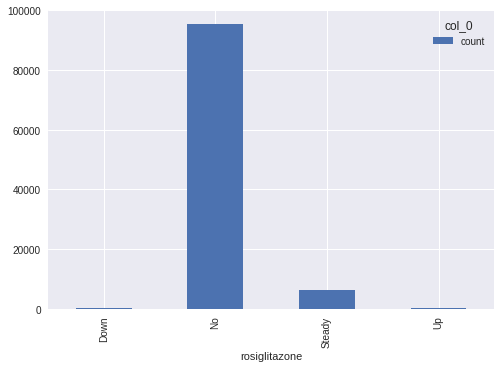

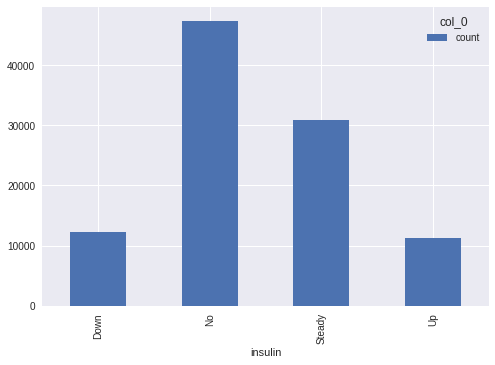

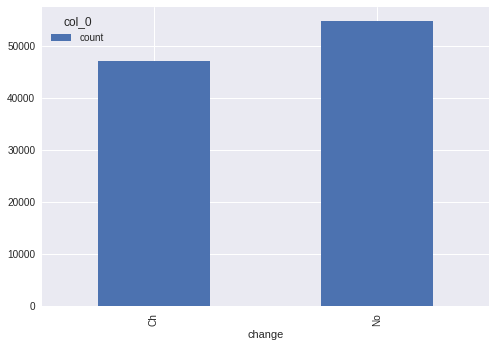

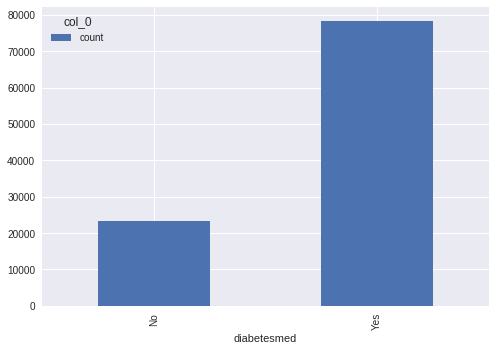

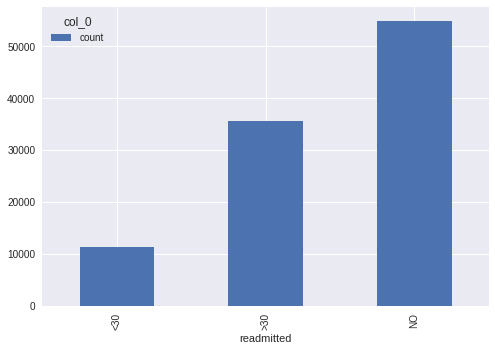

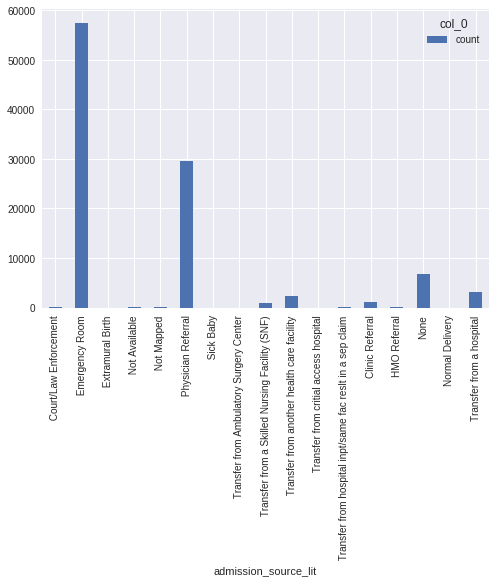

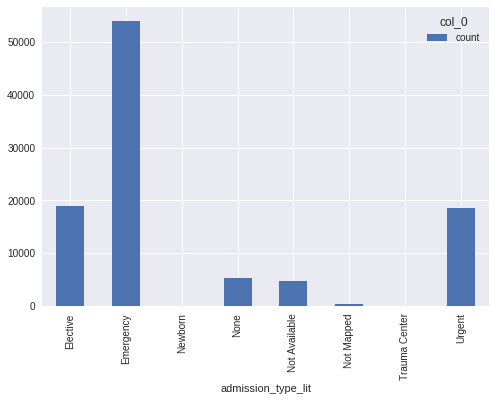

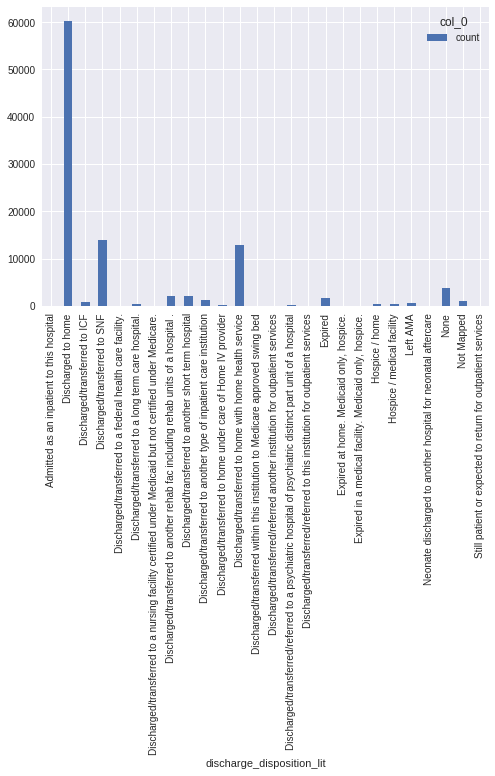

In [231]:
# Genero un gráfico de barras para cada uno de las variables.

col_names= var_categorical.columns
for i, col_val in enumerate(col_names):
  graf= pd.crosstab(index = var_categorical[col_val],  # TABLA DE FRECUENCIA
                              columns="count")  
  graf.plot.bar()




### Crear variables dummy en caso que sea conveniente

#### 1) Ya he transformado la variable Readmitted en 0's y 1's

####  2)Por otro lado ver los graficos de frecuencia  veo que:
           Habría que transformar variables: (lo hago en dos apartados siguientes)                 
                  **diag_1,diag_2,diag_3**: podria considerarlas como variables continuas eliminando los caracteres.
                  
                  **Crear variables nuevas**: 
                                Race = transformarla a numérica o Crear una variable nueva cuando se es caucasico o  afroamericano.
                                max_glu_serum= 1 cuando es None y 0 para el resto.
                                a1cresult = 1 cuando es None y 0 para el resto.
                                metformin = 1 cuando es No y 0 para el resto.
                                glimepiride= 1 cuando es No y 0 para el resto.
                                glipizide = 1 cuando es No y 0 para el resto.
                                glyburide = 1 cuando es No y 0 para el resto.
                                pioglitazone = 1 cuando es No y 0 para el resto.
                                rosiglitazone=1 cuando es No y 0 para el resto.      
                                **texto en negrita**

#### Análizo  las variables que quiero transformar calculando el porcentaje de valores None o No en cada variable, usando variables dummies.

In [232]:
names=['max_glu_serum', 'a1cresult','metformin','glimepiride','glipizide', 'glyburide']

for i, col in enumerate(names):
  print(col, " ", var_categorical[col].value_counts()/(var_categorical.shape[0])*100)
 

max_glu_serum   None    94.746772
Norm    2.551933 
>200    1.459230 
>300    1.242065 
Name: max_glu_serum, dtype: float64
a1cresult   None    83.277322
>8      8.073423 
Norm    4.903406 
>7      3.745848 
Name: a1cresult, dtype: float64
metformin   No        80.358862
Steady    18.027632
Up        1.048484 
Down      0.565022 
Name: metformin, dtype: float64
glimepiride   No        94.899082
Steady    4.588959 
Up        0.321325 
Down      0.190633 
Name: glimepiride, dtype: float64
glipizide   No        87.534147
Steady    11.158933
Up        0.756638 
Down      0.550282 
Name: glipizide, dtype: float64
glyburide   No        89.534815
Steady    9.113063 
Up        0.797909 
Down      0.554213 
Name: glyburide, dtype: float64


####*Variables Dummy *

#### max_glu_serum:

In [233]:
#names=['max_glu_serum', 'a1cresult','metformin','glimepiride','glipizide', 'glyburide']
#for i, col in enumerate(names):
 
dum_maxglu = pd.get_dummies(diabetes['max_glu_serum'])
diabetes_dummies = pd.concat([diabetes, dum_maxglu], axis=1) 

#Cambio los nombres de las columnas para luego borrar
diabetes_dummies=diabetes_dummies.rename(columns={'None':'dum_max_glu_serum', '>200': 'glu_min200', '>300':'glu_min300'})

#Borrar
col_del= ['glu_min200', 'glu_min300', 'Norm']

#Mostrar
diabetes_dummies.drop(col_del, axis='columns', inplace=True)

#Borrar
diabetes_dummies.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,change,diabetesmed,readmitted,admission_source_lit,admission_type_lit,discharge_disposition_lit,readmitted_max30,readmitted_min30,readmitted_num,dum_max_glu_serum
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,,...,No,No,NO,Physician Referral,None,Not Mapped,0,0,1,1
1,1968528,720936,Caucasian,Female,[70-80),6,25,1,10,,...,Ch,Yes,>30,Physician Referral,None,Not Mapped,0,1,0,1
2,2223336,558360,AfricanAmerican,Female,[60-70),6,25,1,9,,...,No,No,NO,Physician Referral,None,Not Mapped,0,0,1,1
3,2298006,2519748,Caucasian,Male,[60-70),6,25,1,4,,...,Ch,Yes,NO,Physician Referral,None,Not Mapped,0,0,1,1
4,2356308,608841,AfricanAmerican,Female,[50-60),6,25,1,1,,...,No,Yes,>30,Physician Referral,None,Not Mapped,0,1,0,1


#### **a1cresult**

In [0]:
#NO LO HE TERMINADO
dum_a1cresult = pd.get_dummies(diabetes['a1cresult'])
diabetes_dummies = pd.concat([diabetes, dum_a1cresult], axis=1) 

#Cambio los nombres de las columnas para luego borrar
diabetes_dummies=diabetes_dummies.rename(columns={'None':'dum_a1cresult', '>200': 'a1_min200', '>300':'a1_min300'})

#Borrar
col_del= ['glu_min200', 'glu_min300', 'Norm']

#Mostrar
diabetes_dummies.drop(col_del, axis='columns', inplace=True)

#Borrar
diabetes_dummies.head()



### Estudiar que todas las variables ahora sí tengan el formato y contenido adecuado. si todavía no, arreglarlas.

#### Tranformar la variable


In [0]:
# Luego de transformar el dataframes de variables categoricas y variables numéricas

# Variables Categóricas
list(set(diabetes.dtypes.tolist()))
var_categorical = diabetes.select_dtypes(include = ['O'])

  
# Variables Numéricas
list(set(diabetes.dtypes.tolist()))
var_numerical = diabetes.select_dtypes(include = ['float64', 'int64'])


In [0]:
var_numerical.info()





# Exploratory Data Analysis



### Crear la matriz de correlación

### *Correlación sin eliminar Outliers*

In [0]:
diabetes.columns

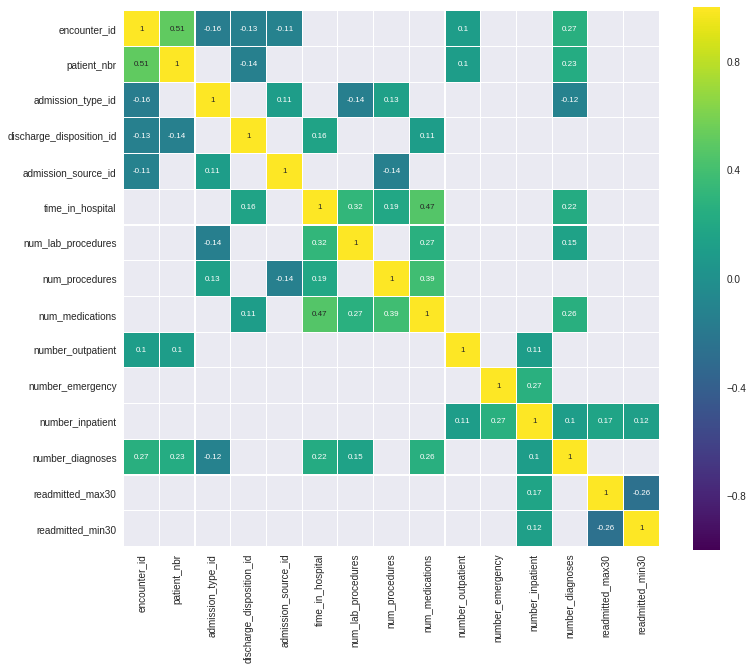

In [234]:
#ADAPTAR CODIGO
corr = diabetes.drop('readmitted_num', axis=1).corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);



### Pintar la matriz de correlación

#### Pinto sólo los que tienen correlación positia y negativa.

In [235]:
corr = diabetes.drop('readmitted_num', axis=1).corr() 
corr

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted_max30,readmitted_min30
encounter_id,1.000000,0.512028,-0.158961,-0.132876,-0.112402,-0.062221,-0.026062,-0.014225,0.076113,0.103756,0.082803,0.030962,0.265149,-0.008519,-0.034384
patient_nbr,0.512028,1.000000,-0.011128,-0.136814,-0.032568,-0.024092,0.015946,-0.015570,0.020665,0.103379,0.062352,0.012480,0.226847,0.007893,0.072256
admission_type_id,-0.158961,-0.011128,1.000000,0.083483,0.106654,-0.012500,-0.143713,0.129888,0.079535,0.026511,-0.019116,-0.038161,-0.117126,-0.011651,0.002548
discharge_disposition_id,-0.132876,-0.136814,0.083483,1.000000,0.018193,0.162748,0.023415,0.015921,0.108753,-0.008715,-0.024471,0.020787,0.046891,0.050560,-0.048922
admission_source_id,-0.112402,-0.032568,0.106654,0.018193,1.000000,-0.006965,0.048885,-0.135400,-0.054533,0.027244,0.059892,0.036314,0.072114,0.005820,0.037964
time_in_hospital,-0.062221,-0.024092,-0.012500,0.162748,-0.006965,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186,0.044199,0.024434
num_lab_procedures,-0.026062,0.015946,-0.143713,0.023415,0.048885,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773,0.020364,0.027592
num_procedures,-0.014225,-0.015570,0.129888,0.015921,-0.135400,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734,-0.012227,-0.038711
num_medications,0.076113,0.020665,0.079535,0.108753,-0.054533,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526,0.038432,0.023521
number_outpatient,0.103756,0.103379,0.026511,-0.008715,0.027244,-0.008916,-0.007602,-0.024819,0.045197,1.000000,0.091459,0.107338,0.094152,0.018893,0.073406


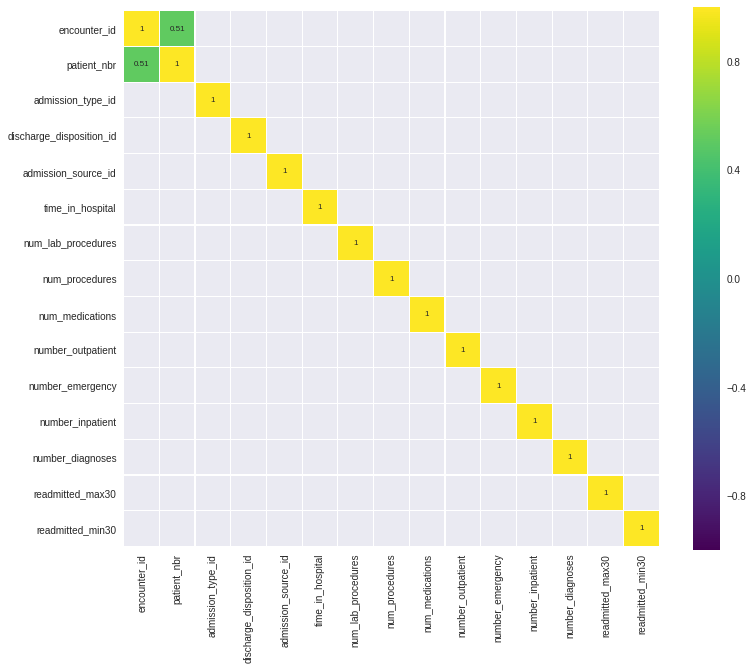

In [236]:

#corr = diabetes.drop('readmitted_num', axis=1).corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);




### Determinar qué par de variables están correlacionadas

In [237]:
# Relacion entre dos variables
                       
corr_val= (corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool)).stack().sort_values(ascending=False))     
corr_val

encounter_id              patient_nbr                 0.512028
time_in_hospital          num_medications             0.466135
num_procedures            num_medications             0.385767
time_in_hospital          num_lab_procedures          0.318450
num_lab_procedures        num_medications             0.268161
number_emergency          number_inpatient            0.266559
encounter_id              number_diagnoses            0.265149
num_medications           number_diagnoses            0.261526
patient_nbr               number_diagnoses            0.226847
time_in_hospital          number_diagnoses            0.220186
                          num_procedures              0.191472
number_inpatient          readmitted_max30            0.165147
discharge_disposition_id  time_in_hospital            0.162748
num_lab_procedures        number_diagnoses            0.152773
admission_type_id         num_procedures              0.129888
number_inpatient          readmitted_min30            0